# Análise e Visualização da Camada Gold

Este notebook contém as funções de visualização e recomendação baseadas nos dados da camada Gold.

In [56]:
!pip install pandas matplotlib pyarrow fastparquet numpy plotly scikit-learn nbformat

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

# Configuração de diretórios
# Assume que o notebook está rodando em bigdata/notebooks
BASE_DIR = os.path.abspath("..")
SILVER_DIR = os.path.join(BASE_DIR, "dados", "silver")
GOLD_DIR = os.path.join(BASE_DIR, "dados", "gold")

print(f"Base Dir: {BASE_DIR}")
print(f"Silver Dir: {SILVER_DIR}")
print(f"Gold Dir: {GOLD_DIR}")

Base Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata
Silver Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata/dados/silver
Gold Dir: /Users/Jonathas/Desktop/college-code/big-data/bigdata/dados/gold


## Função de Recomendação

In [58]:
def recommend(user_id: int, n: int = 10) -> pd.DataFrame:
    scores = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")
    profiles = pd.read_parquet(f"{GOLD_DIR}/user_genre_profiles.parquet")
    ratings = pd.read_parquet(f"{SILVER_DIR}/ratings_clean.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")


    pref = profiles[profiles["userId"] == user_id]
    if pref.empty:
        print("Usuário sem histórico suficiente.")
        return pd.DataFrame()

    fav_genre = pref.sort_values("rating_mean", ascending=False).iloc[0]["genre"]
    print(f"Gênero favorito do usuário {user_id}: {fav_genre}")


    rated_ids = set(ratings[ratings["userId"] == user_id]["movieId"].unique())


    df = movies.explode("genres_list", ignore_index=True)
    df["genre"] = df["genres_list"].apply(lambda d: d.get("name") if isinstance(d, dict) else None)
    df = df[df["genre"] == fav_genre]


    df = df.merge(
        scores[["id", "weighted_rating"]],
        left_on="id",
        right_on="id",
        how="inner"
    )


    df = df[~df["id"].isin(rated_ids)]


    df = df.sort_values("weighted_rating", ascending=False)


    return df[["id", "title", "genre", "weighted_rating"]].head(n)

## Visualizações Gráficas

In [59]:
# 1) Gráfico — Distribuição do Weighted Rating
def plot_weighted_rating_distribution():
    df = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")

    plt.figure(figsize=(10, 6))
    df["weighted_rating"].hist(bins=40)
    plt.title("Distribuição do Weighted Rating")
    plt.xlabel("Weighted Rating")
    plt.ylabel("Frequência")
    plt.show()

In [79]:
# 2) Gráfico — Top 20 filmes por Weighted Rating
def generate_top_movies_chart():
    df_scores = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")
    top_movies = df_scores.nlargest(20, "weighted_rating")
    fig_top = px.bar(
        top_movies, 
        x="weighted_rating", 
        y="title", 
        orientation='h',
        title="Top 20 Filmes (Weighted Rating)",
        labels={"weighted_rating": "Nota Ponderada", "title": "Filme"},
        color="weighted_rating",
        color_continuous_scale="Viridis"
    )
    # Inverter eixo Y para o melhor ficar no topo
    fig_top.update_layout(yaxis={'categoryorder':'total ascending'})
    fig_top.show()

In [61]:
#Gráfico 3 — Relação entre orçamento e receita (scatter)

# na casa do milhao
def plot_budget_revenue_relation():
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    df = movies.dropna(subset=["budget", "revenue"])
    df = df[(df["budget"] > 0) & (df["revenue"] > 0)]  # evitar zeros

    plt.figure(figsize=(8,6))
    plt.scatter(df["budget"], df["revenue"], alpha=0.3)
    plt.title("Relação entre Orçamento (Budget) e Receita (Revenue)")
    plt.xlabel("Budget")
    plt.ylabel("Revenue")
    plt.show()


In [62]:
# Gráfico 4 — Distribuição de gêneros mais populares (por quantidade de filmes)

def generate_genre_popularity_chart():
    df_profiles = pd.read_parquet(f"{GOLD_DIR}/user_genre_profiles.parquet")
    genre_metrics = df_profiles.groupby("genre").agg(
        avg_rating=("rating_mean", "mean"),
        total_ratings=("n_ratings", "sum"),
        user_count=("userId", "nunique")
    ).reset_index().sort_values("total_ratings", ascending=False)

    fig_genre = px.bar(
        genre_metrics,
        x="genre",
        y="total_ratings",
        color="avg_rating",
        title="Popularidade dos Gêneros (Total de Avaliações vs Média de Notas)",
        labels={
            "genre": "Gênero", 
            "total_ratings": "Total de Avaliações", 
            "avg_rating": "Média das Notas dos Usuários"
        },
        color_continuous_scale="RdBu",
        hover_data=["user_count"]
    )
    fig_genre.show()


In [63]:
def plot_corr_weighted_vs_voteavg():
    import pandas as pd
    import matplotlib.pyplot as plt
    
    scores = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")

    plt.figure(figsize=(8,6))
    plt.scatter(scores["vote_average"], scores["weighted_rating"], alpha=0.4)
    plt.xlabel("Vote Average (público)")
    plt.ylabel("Weighted Rating (Gold)")
    plt.title("Correlação: Média do Público vs Weighted Rating")
    plt.grid(True, alpha=0.2)
    plt.show()

In [64]:
def scatter_user_genre_clusters(user_id: int, genre: str, k_clusters: int = 3, limit_points=500):
    import pandas as pd
    import plotly.express as px
    from sklearn.cluster import KMeans
    import numpy as np

    # carregar dados
    ratings = pd.read_parquet(f"{SILVER_DIR}/ratings_clean.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    # corrigir dtypes
    ratings["movieId"] = pd.to_numeric(ratings["movieId"], errors="coerce").astype("Int64")
    movies["id"]       = pd.to_numeric(movies["id"], errors="coerce").astype("Int64")

    # expandir gêneros
    mov_exp = movies.explode("genres_list", ignore_index=True)
    mov_exp["genre"] = mov_exp["genres_list"].apply(lambda d: d.get("name") if isinstance(d, dict) else None)

    mov_genre = mov_exp[mov_exp["genre"] == genre]

    user = ratings[ratings["userId"] == user_id]

    df = user.merge(
        mov_genre[["id", "title", "popularity"]],
        left_on="movieId",
        right_on="id",
        how="inner"
    )

    if df.empty:
        print(f"Usuário {user_id} não avaliou filmes do gênero '{genre}'.")
        return

    # limitar pontos para visualização
    if len(df) > limit_points:
        df = df.sample(limit_points, random_state=42)

    # preparar dados para clustering
    X = df[["rating", "popularity"]].copy()

    # normalizar leve se quiser (não obrigatório)
    X = (X - X.mean()) / X.std()

    # clustering
    km = KMeans(n_clusters=k_clusters, n_init=10, random_state=42)
    df["cluster"] = km.fit_predict(X)

    # scatter interativo
    fig = px.scatter(
        df,
        x="rating",
        y="popularity",
        color="cluster",
        hover_data=["title", "rating", "popularity", "cluster"],
        title=f"User {user_id}: Clusters de Gosto — Gênero '{genre}'",
        labels={"rating": "Nota do Usuário", "popularity": "Popularidade"}
    )

    fig.update_traces(marker=dict(size=10, opacity=0.8))
    fig.show()


In [65]:
def plot_genre_weighted_scores():
    import pandas as pd
    import matplotlib.pyplot as plt

    scores = pd.read_parquet(f"{GOLD_DIR}/movies_scores.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    df = movies.merge(scores[["id","weighted_rating"]], on="id", how="inner")
    df = df.explode("genres_list", ignore_index=True)

    df["genre"] = df["genres_list"].apply(
        lambda d: d.get("name") if isinstance(d, dict) else None
    )

    genre_scores = df.groupby("genre")["weighted_rating"].mean().sort_values()

    plt.figure(figsize=(12,6))
    plt.barh(genre_scores.index, genre_scores.values)
    plt.title("Média do Weighted Rating por Gênero")
    plt.xlabel("Weighted Rating Médio")
    plt.show()


## Teste de Recomendação

In [66]:
def test_recommendation_example():
    print("\n=== Teste de Recomendação ===")

    profiles = pd.read_parquet(f"{GOLD_DIR}/user_genre_profiles.parquet")
    example_user = profiles["userId"].sample(1).iloc[0]

    print(f"Usuário de teste: {example_user}")

    recs = recommend(example_user, n=10)

    print("\nTop 10 recomendações:")
    print(recs[["title", "weighted_rating"]])

In [67]:
def plot_recommendation_score_distribution(user_id=1, n=20):
    recs = recommend(user_id, n)

    if recs.empty:
        print("Usuário sem recomendações suficientes.")
        return

    plt.figure(figsize=(10,5))
    plt.hist(recs["weighted_rating"], bins=10)
    plt.title(f"Distribuição do Weighted Rating das Recomendações (user {user_id})")
    plt.xlabel("Weighted Rating")
    plt.ylabel("Frequência")
    plt.show()


In [68]:
def compare_user_vs_public(user_id: int, max_filmes: int = 20):

    ratings = pd.read_parquet(f"{SILVER_DIR}/ratings_clean.parquet")
    movies = pd.read_parquet(f"{SILVER_DIR}/movies_clean.parquet")

    ratings["movieId"] = pd.to_numeric(ratings["movieId"], errors="coerce").astype("Int64")
    ratings["userId"]  = pd.to_numeric(ratings["userId"], errors="coerce").astype("Int64")
    movies["id"]       = pd.to_numeric(movies["id"], errors="coerce").astype("Int64")

    user = ratings[ratings["userId"] == user_id].copy()
    if user.empty:
        print(f"O usuário {user_id} não avaliou nenhum filme.")
        return

    public_mean = (
        ratings
        .groupby("movieId")["rating"]
        .mean()
        .reset_index()
        .rename(columns={"rating": "public_mean"})
    )

    df = user.merge(public_mean, on="movieId", how="left")

    df = df.merge(movies[["id", "title"]], left_on="movieId", right_on="id", how="left")

    df = df.sort_values(by="rating", ascending=False).head(max_filmes)

    fig = px.bar(
        df,
        y="title",
        x=["rating", "public_mean"],
        orientation="h",
        title=f"Comparação: Avaliação do Usuário {user_id} vs Média do Público",
        labels={"value": "Nota", "title": "Filme"},
        barmode="group",
        hover_data={"movieId": True, "title": False}
    )

    fig.update_yaxes(autorange="reversed")
    fig.show()


## Execução dos Gráficos e Testes

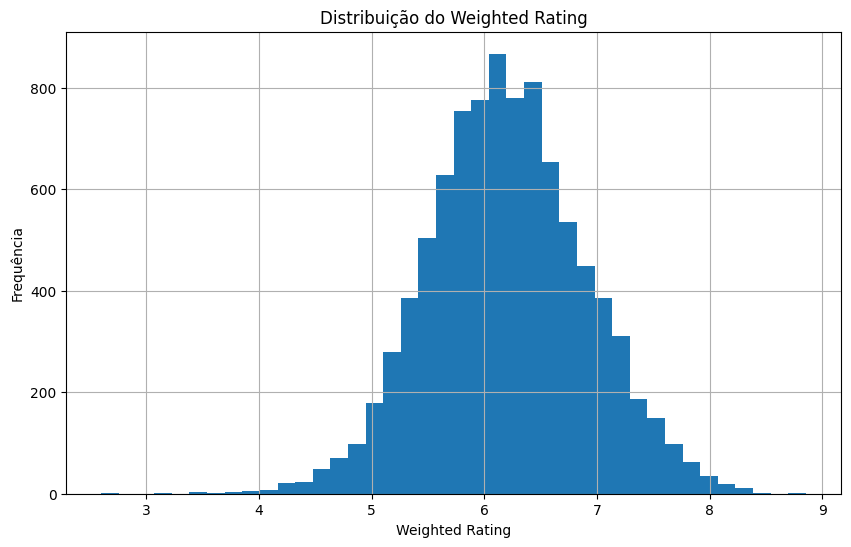

In [69]:
plot_weighted_rating_distribution()

In [80]:
generate_top_movies_chart()

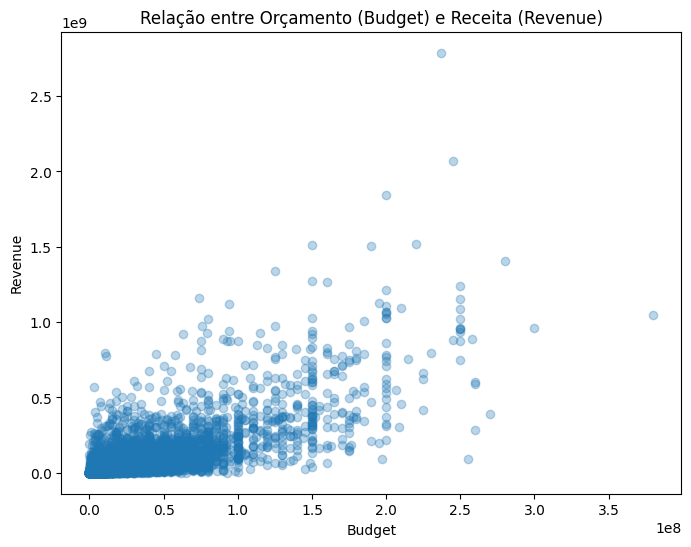

In [71]:
plot_budget_revenue_relation()

In [72]:
generate_genre_popularity_chart()

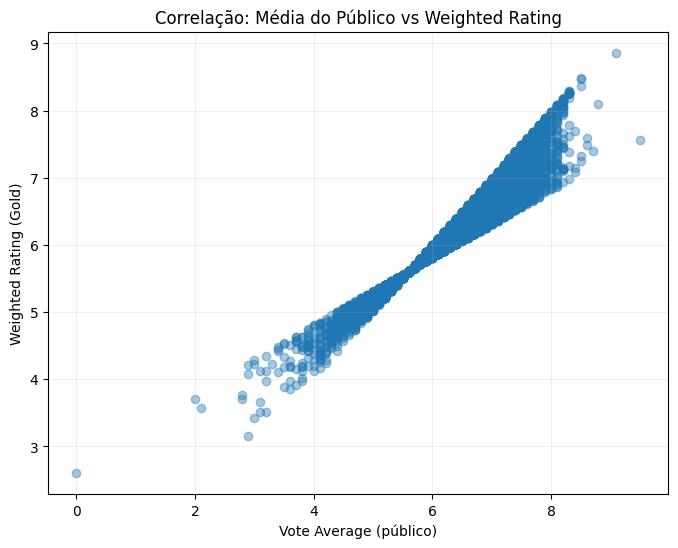

In [73]:
plot_corr_weighted_vs_voteavg()

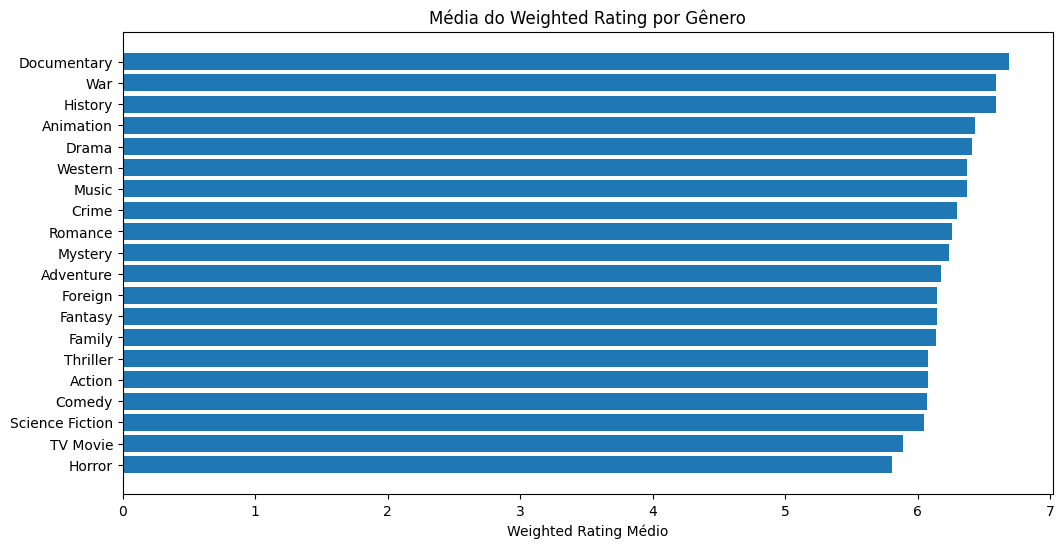

In [74]:
plot_genre_weighted_scores()

In [75]:
test_recommendation_example()


=== Teste de Recomendação ===
Usuário de teste: 10344
Gênero favorito do usuário 10344: Adventure

Top 10 recomendações:
                                                  title  weighted_rating
457                                       Spirited Away         8.266629
93                              The Empire Strikes Back         8.178657
635                                Howl's Moving Castle         8.138502
273                                   Princess Mononoke         8.138267
894                                           Inception         8.091215
1067                                       Interstellar         8.088958
532       The Lord of the Rings: The Return of the King         8.085007
22                                            Star Wars         8.081827
416   The Lord of the Rings: The Fellowship of the Ring         7.986683
475               The Lord of the Rings: The Two Towers         7.984517


Gênero favorito do usuário 400: War


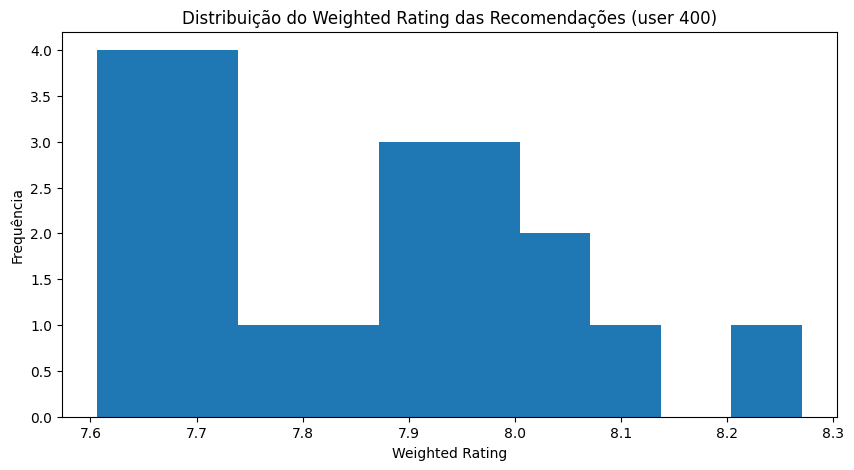

In [76]:
plot_recommendation_score_distribution(user_id=400)

In [77]:
compare_user_vs_public(user_id=10, max_filmes=20)